## Compare two nocompy runs with different allometries to plot data size distributions

### Libraries

In [1]:
import numpy as np
import xarray as xr
import csv
import pandas as pd

import functions_py.fates_xarray_functions as fa

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import cartopy.crs as ccrs
from matplotlib import cm

### Functions

### Data

#### Load Piponiot data - AGB AWM and AWP by size

In [63]:
df_pip = pd.read_csv('/global/homes/j/jneedham/plot_data/Piponiot_2022_NewPhyt_AGB_AWP_AWM_standard_size_class.csv')
df_pip.head(3)

,site,variable,size_class,total,lower_bound,upper_bound
0,Amacayacu,AGB,"[1,5)",4.667,4.577,4.756
1,Amacayacu,AGB,"[5,10)",13.352,13.066,13.625
2,Amacayacu,AGB,"[10,20)",40.574,39.664,41.437


#### Load Piponiot data - coordinates for each plot

In [80]:
df_pip_latlon = pd.read_csv('/global/homes/j/jneedham/plot_data/Piponiot_2022_totals.csv')
df_pip_latlon.head(6)

,Site,Lat,Lon,AGB,AGB_l,AGB_u,AWP,AWP_l,AWP_u,AWM,AWM_l,AWM_u
0,Lenda,1.315,28.65,482.0,460.0,504.0,5.19,4.94,5.49,6.72,5.21,8.33
1,Edoro,1.560,28.52,353.0,335.0,372.0,5.23,4.99,5.55,3.94,3.05,4.93
2,Pasoh,2.980,102.31,321.0,309.0,334.0,8.27,8.04,8.53,9.58,8.46,10.90
3,Amacayacu,-3.810,-70.27,288.0,277.0,299.0,4.14,3.92,4.36,5.62,5.07,6.19
4,Lambir,4.190,114.02,518.0,501.0,534.0,8.58,8.37,8.82,6.57,5.79,7.45
5,Korup,5.070,8.85,362.0,342.0,382.0,4.29,4.03,4.54,5.87,5.00,6.79


In [84]:
pip_lats = df_pip_latlon.Lat
pip_lons = df_pip_latlon.Lon
# convert to 0 to 360
def convert_longitude(lon):
    return (lon + 360) % 360

pip_lons  = [convert_longitude(lon) for  lon in pip_lons]

pip_names = df_pip_latlon.Site
n_plots = len(pip_lats)

#### Load FATES runs

In [85]:
fates_allom = '/pscratch/sd/j/jneedham/elm_runs/fbnc_cal/fbnc_f45_allom_v3.Eb8be65d66e-Ffc130cb8.2023-10-03/run/fbnc_f45_allom_v3.Eb8be65d66e-Ffc130cb8.2023-10-03.1990s.nc'
fates_allom = xr.open_dataset(fates_allom,  decode_times=False)

fates = '/pscratch/sd/j/jneedham/elm_runs/fbnc_cal/fbnc_f45_allom_v3_defaults.Eb8be65d66e-Ffc130cb8.2023-10-03/run/fbnc_f45_allom_v3_defaults.Eb8be65d66e-Ffc130cb8.2023-10-03.1990s.nc'
fates = xr.open_dataset(fates,  decode_times=False)

time = fates.variables['time'] / 365.
cohort_size_bins = fates.variables['fates_levscls'][:]
nsizebins = len(cohort_size_bins)

### AGB

#### Data

In [86]:
data_mids = [3, 7.5, 15, 25, 35, 45, 75, 150, 350]
data_widths = [4, 5, 10, 10, 10, 10, 50, 100, 300]
data_agb =  df_pip[df_pip['variable'] == 'AGB']
print(data_agb.head(3))

        site variable size_class   total  lower_bound  upper_bound
0  Amacayacu      AGB      [1,5)   4.667        4.577        4.756
1  Amacayacu      AGB     [5,10)  13.352       13.066       13.625
2  Amacayacu      AGB    [10,20)  40.574       39.664       41.437


#### FATES

In [87]:
cohort_size_bins_ex  = np.append(cohort_size_bins,200)
fates_mids = (cohort_size_bins_ex[0:-1] + cohort_size_bins_ex[1:])/2
fates_widths = cohort_size_bins_ex[1:] - cohort_size_bins_ex[0:-1]

In [88]:
fates_agb = fa.scpf_to_scls_by_pft(fates.FATES_VEGC_ABOVEGROUND_SZPF, fates)  # untangle size and pft dimensions
fates_agb = fates_agb.sum(dim='fates_levpft') # sum over pfts
fates_agb = fates_agb.mean(dim='time') * 10  # mean over time and convert kg m-2 to Megagrams ha-1

fates_allom_agb = fa.scpf_to_scls_by_pft(fates_allom.FATES_VEGC_ABOVEGROUND_SZPF, fates_allom)  # untangle size and pft dimensions
fates_allom_agb = fates_allom_agb.sum(dim='fates_levpft') # sum over pfts
fates_allom_agb = fates_allom_agb.mean(dim='time') * 10  # mean over time and convert kg m-2 to Megagrams ha-1

In [89]:
agbs = []
agbs_allom = []

# extract grid cells
for i in range(0,n_plots) : 
    agbs.append(fates_agb.sel(lat=pip_lats[i], lon=pip_lons[i], method='nearest'))
    agbs_allom.append(fates_allom_agb.sel(lat=pip_lats[i], lon=pip_lons[i], method='nearest'))

#### Plot them

Text(0.5, 0.01, 'DBH (cm)')

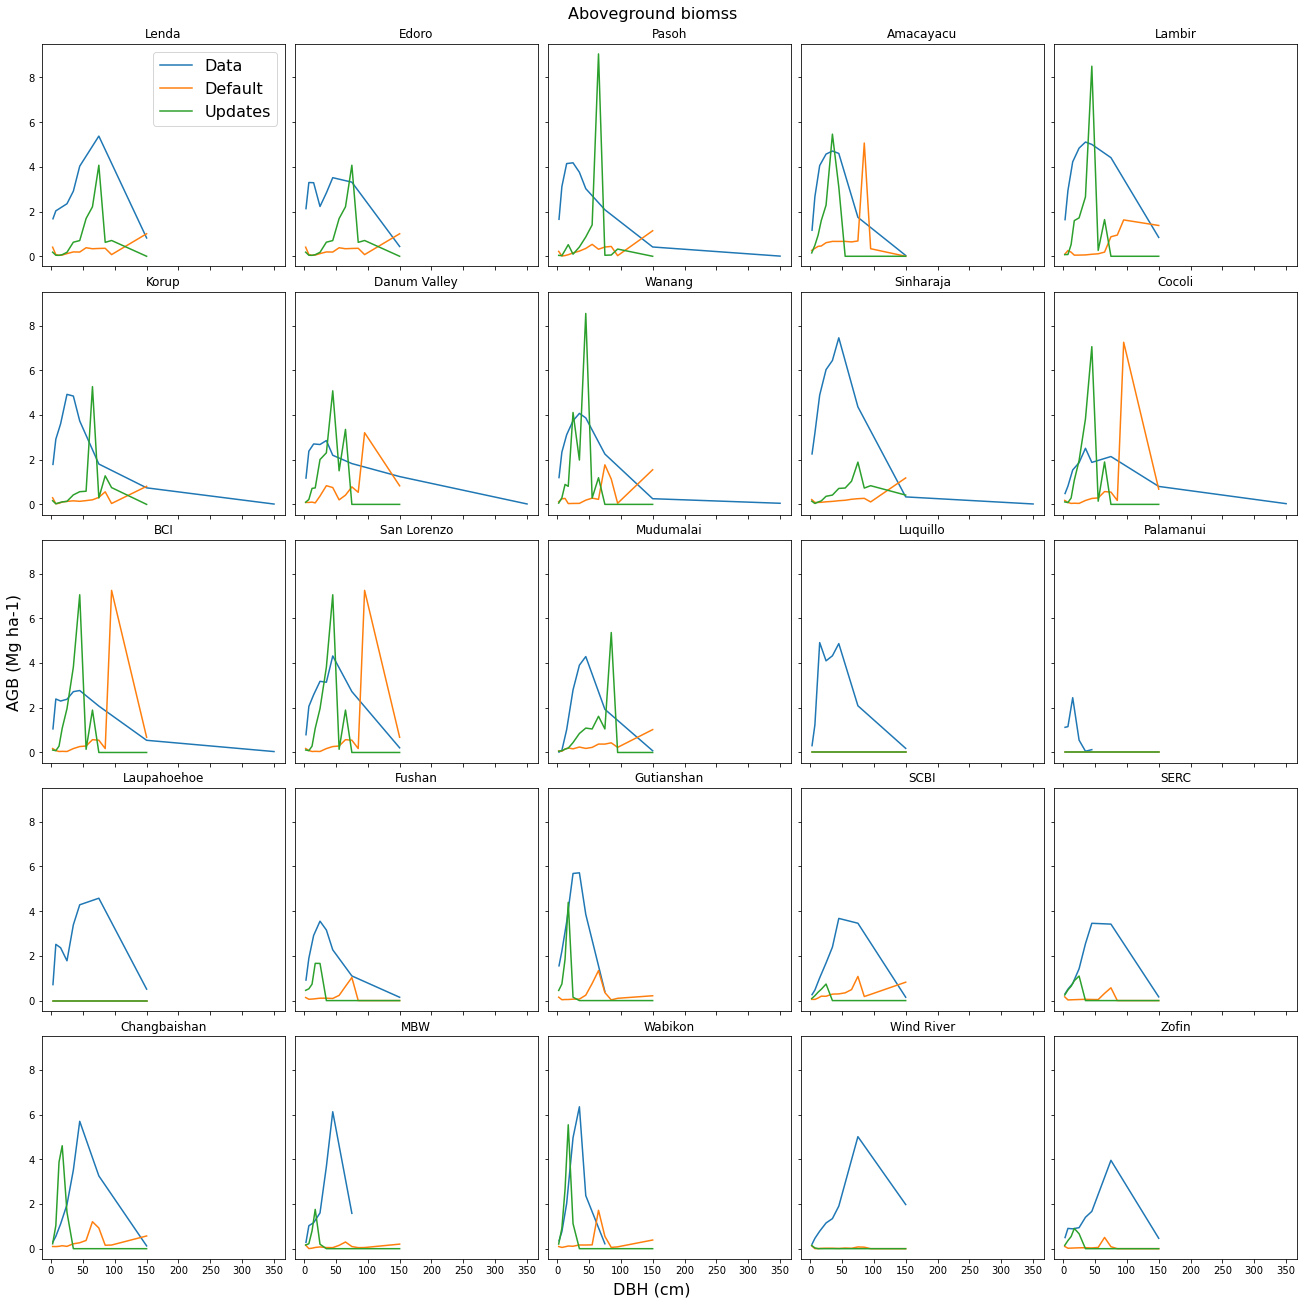

In [90]:
fig, axs = plt.subplots(nrows=5,ncols=5,
                        figsize=(18,18),sharex=True, sharey=True, constrained_layout=True)
axs=axs.flatten()

for i in range(0,n_plots):
    
        name = pip_names[i]
        plot_agb = data_agb[data_agb['site'] == name].total
        plot_mids = data_mids[0:len(plot_agb)]
        plot_widths = data_widths[0:len(plot_agb)]
        
        axs[i].plot(plot_mids, plot_agb/plot_widths, label = 'Data')
        axs[i].plot(fates_mids, agbs[i]/fates_widths, label = 'Default')
        axs[i].plot(fates_mids, agbs_allom[i]/fates_widths, label = 'Updates')
        axs[i].set_title(name)
        
        if i == 0 : 
            axs[i].legend(fontsize=16)

fig.suptitle('Aboveground biomss', fontsize=16)
fig.supylabel('AGB (Mg ha-1)', fontsize=16)
fig.supxlabel('DBH (cm)', fontsize=16)



### AWP  - aboveground woody productivity

In [98]:
# data
data_awp =  df_pip[df_pip['variable'] == 'AWP']

In [99]:
# fates
fates_awp = fa.scpf_to_scls_by_pft(fates.FATES_ABOVEGROUND_PROD_SZPF, fates)  # untangle size and pft dimensions
fates_awp = fates_awp.sum(dim='fates_levpft') # sum over pfts
fates_awp = fates_awp.mean(dim='time') * 10 * 365 * 86400  # mean over time and convert kg m-2 to Megagrams ha-1, and seconds to years

fates_allom_awp = fa.scpf_to_scls_by_pft(fates_allom.FATES_ABOVEGROUND_PROD_SZPF, fates_allom)  # untangle size and pft dimensions
fates_allom_awp = fates_allom_awp.sum(dim='fates_levpft') # sum over pfts
fates_allom_awp = fates_allom_awp.mean(dim='time') * 10 * 365 * 86400 # mean over time and convert kg m-2 to Megagrams ha-1, and seconds to years

In [100]:
awps = []
awps_allom = []

# extract grid cells
for i in range(0,n_plots) : 
    awps.append(fates_awp.sel(lat=pip_lats[i], lon=pip_lons[i], method='nearest'))
    awps_allom.append(fates_allom_awp.sel(lat=pip_lats[i], lon=pip_lons[i], method='nearest'))

Text(0.5, 0.01, 'DBH (cm)')

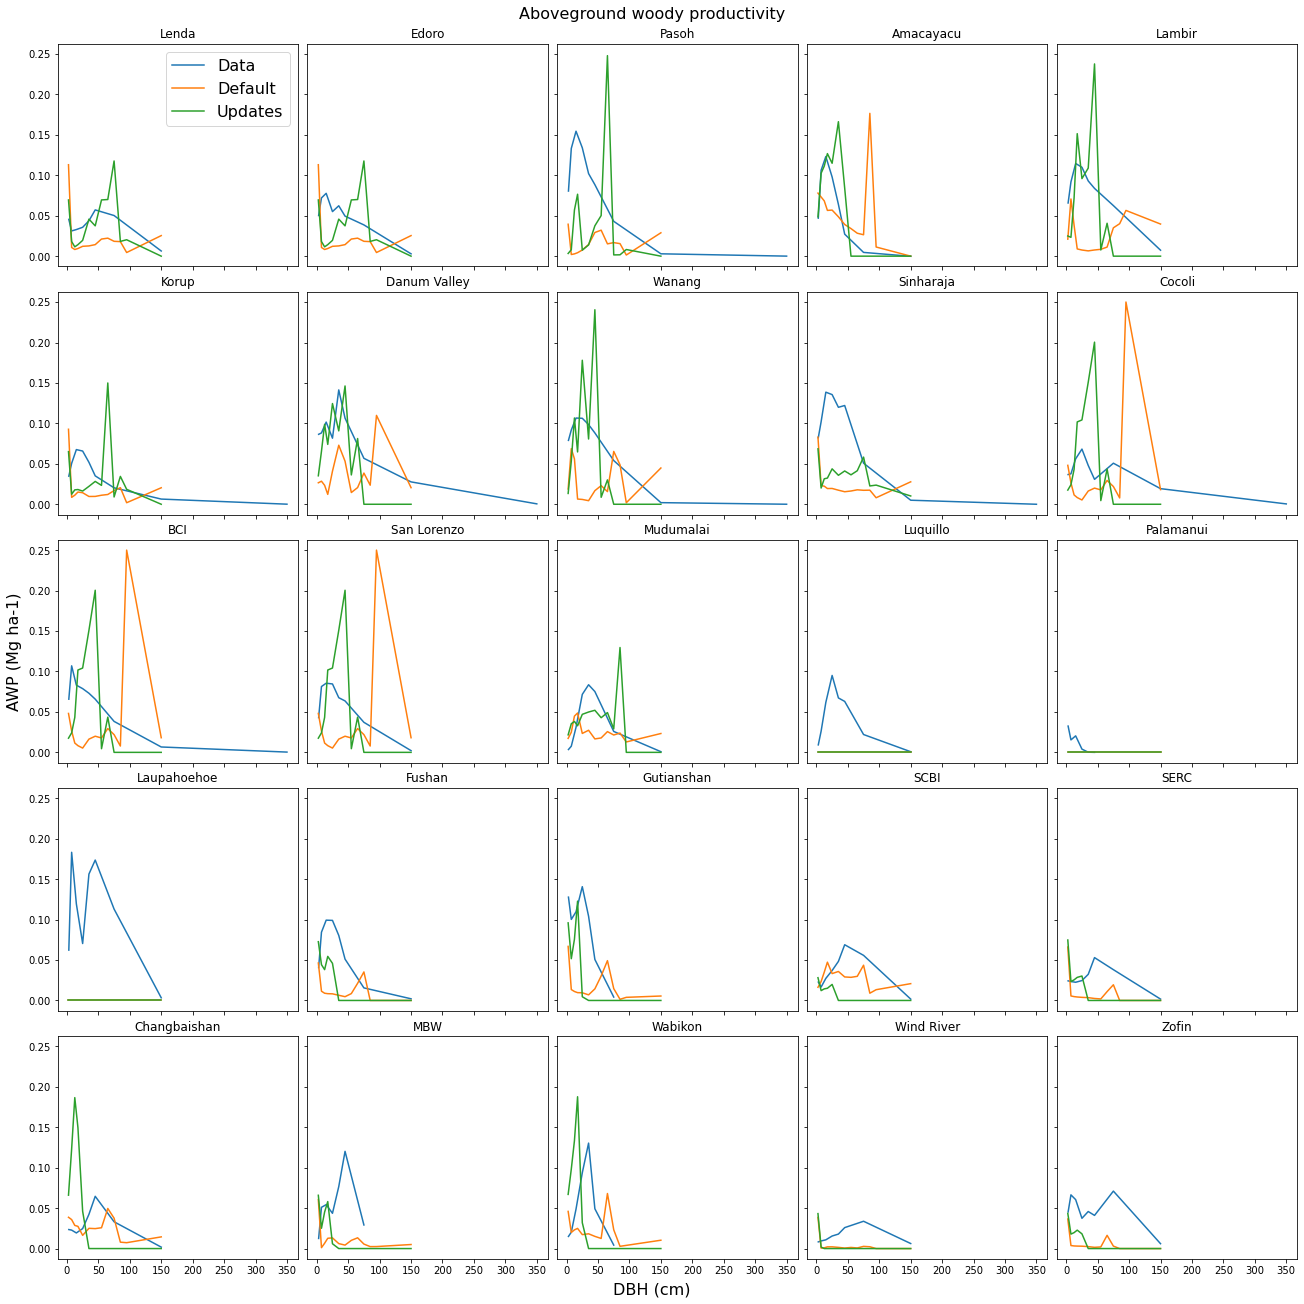

In [101]:
fig, axs = plt.subplots(nrows=5,ncols=5,
                        figsize=(18,18),sharex=True, sharey=True, constrained_layout=True)
axs=axs.flatten()

for i in range(0,n_plots):
    
        name = pip_names[i]
        plot_awp = data_awp[data_awp['site'] == name].total
        plot_mids = data_mids[0:len(plot_awp)]
        plot_widths = data_widths[0:len(plot_awp)]
        
        axs[i].plot(plot_mids, plot_awp/plot_widths, label = 'Data')
        axs[i].plot(fates_mids, awps[i]/fates_widths, label = 'Default')
        axs[i].plot(fates_mids, awps_allom[i]/fates_widths, label = 'Updates')
        axs[i].set_title(name)
        
        if i == 0 : 
            axs[i].legend(fontsize=16)

fig.suptitle('Aboveground woody productivity', fontsize=16)
fig.supylabel('AWP (Mg ha-1)', fontsize=16)
fig.supxlabel('DBH (cm)', fontsize=16)



### AWM - aboveground woody mortality 

In [103]:
# data
data_awm =  df_pip[df_pip['variable'] == 'AWM']

In [104]:
# fates
fates_awm = fa.scpf_to_scls_by_pft(fates.FATES_ABOVEGROUND_MORT_SZPF, fates)  # untangle size and pft dimensions
fates_awm = fates_awm.sum(dim='fates_levpft') # sum over pfts
fates_awm = fates_awm.mean(dim='time') * 10 * 365 * 86400  # mean over time and convert kg m-2 to Megagrams ha-1, and seconds to years

fates_allom_awm = fa.scpf_to_scls_by_pft(fates_allom.FATES_ABOVEGROUND_MORT_SZPF, fates_allom)  # untangle size and pft dimensions
fates_allom_awm = fates_allom_awm.sum(dim='fates_levpft') # sum over pfts
fates_allom_awm = fates_allom_awm.mean(dim='time') * 10 * 365 * 86400 # mean over time and convert kg m-2 to Megagrams ha-1, and seconds to years

In [105]:
awms = []
awms_allom = []

# extract grid cells
for i in range(0,n_plots) : 
    awms.append(fates_awm.sel(lat=pip_lats[i], lon=pip_lons[i], method='nearest'))
    awms_allom.append(fates_allom_awm.sel(lat=pip_lats[i], lon=pip_lons[i], method='nearest'))

Text(0.5, 0.01, 'DBH (cm)')

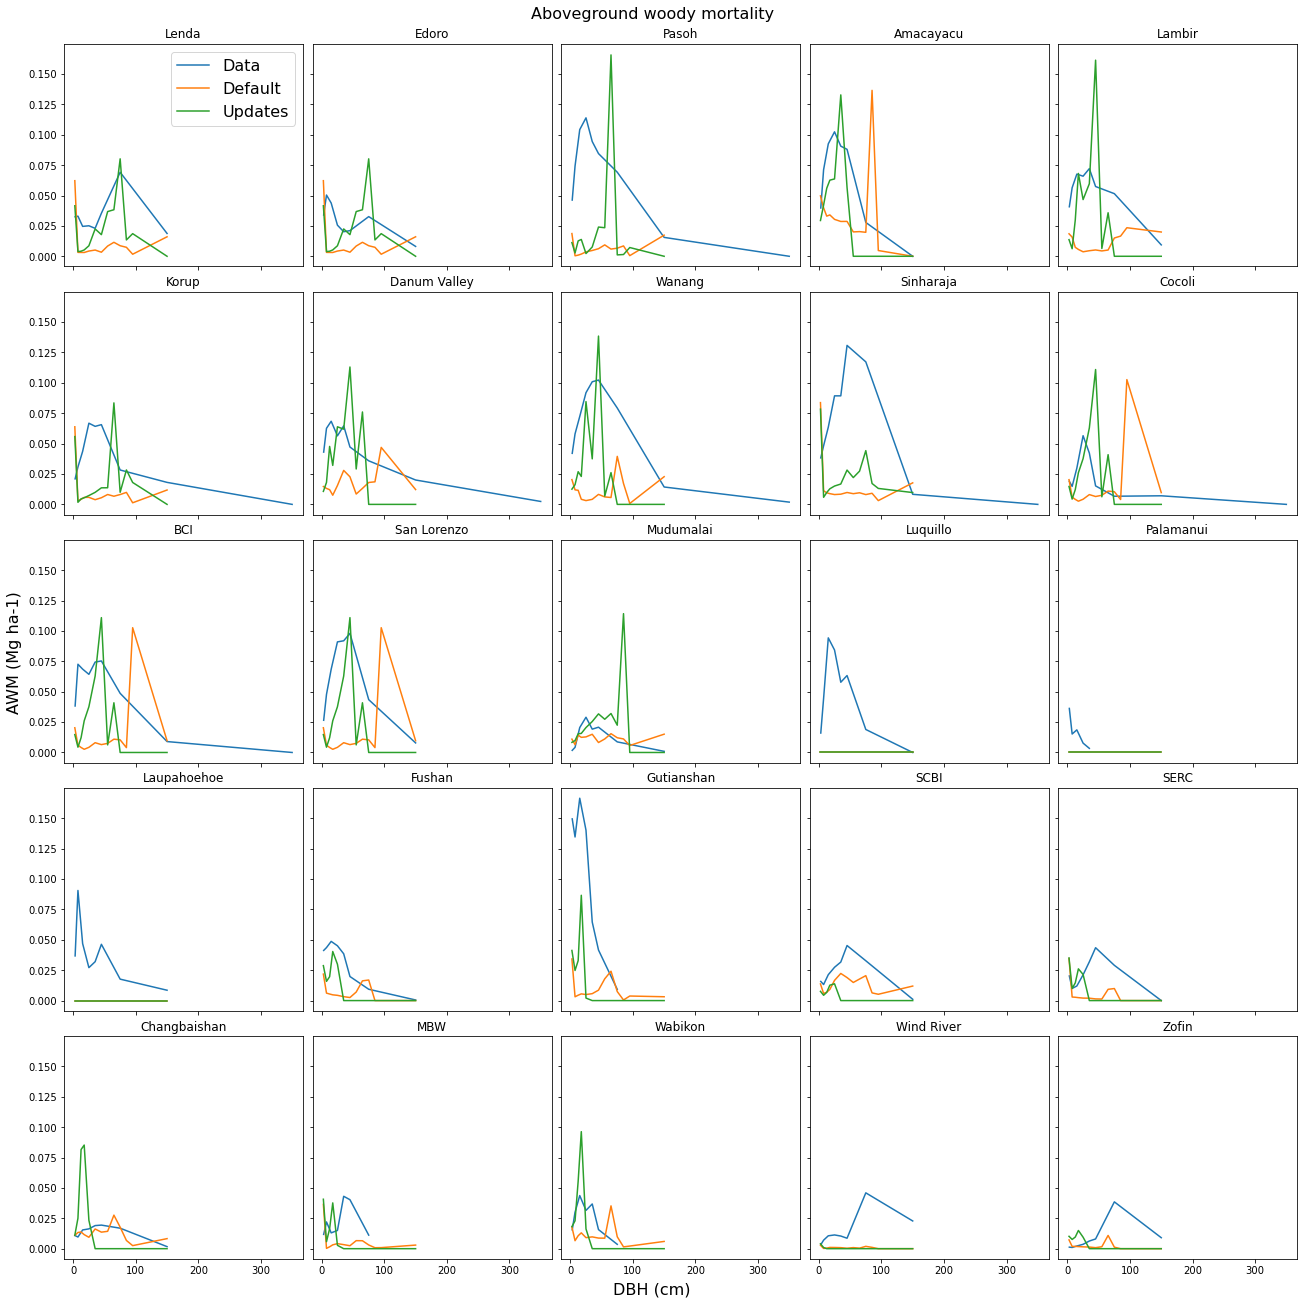

In [106]:
fig, axs = plt.subplots(nrows=5,ncols=5,
                        figsize=(18,18),sharex=True, sharey=True, constrained_layout=True)
axs=axs.flatten()

for i in range(0,n_plots):
    
        name = pip_names[i]
        plot_awm = data_awm[data_awm['site'] == name].total
        plot_mids = data_mids[0:len(plot_awm)]
        plot_widths = data_widths[0:len(plot_awm)]
        
        axs[i].plot(plot_mids, plot_awm/plot_widths, label = 'Data')
        axs[i].plot(fates_mids, awms[i]/fates_widths, label = 'Default')
        axs[i].plot(fates_mids, awms_allom[i]/fates_widths, label = 'Updates')
        axs[i].set_title(name)
        
        if i == 0 : 
            axs[i].legend(fontsize=16)

fig.suptitle('Aboveground woody mortality', fontsize=16)
fig.supylabel('AWM (Mg ha-1)', fontsize=16)
fig.supxlabel('DBH (cm)', fontsize=16)

